In [2]:
import math
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [3]:
import math
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far 
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

In [4]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

In [5]:
import matplotlib.pyplot as plt

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

In [8]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

430/430 [==============================] - 2s 3ms/step - loss: 1.8612 - accuracy: 0.3901


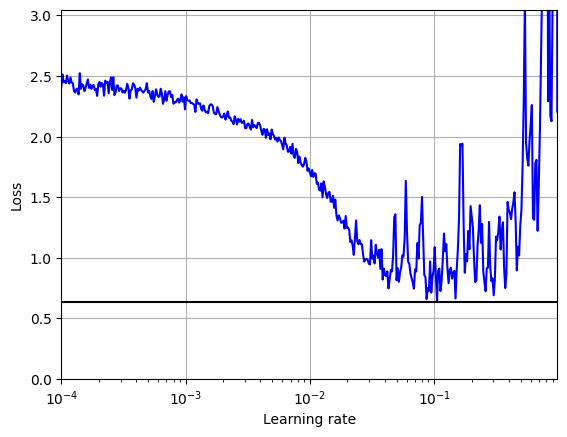

In [9]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [19]:
import tensorflow as tf
import keras.backend as K

class OneCycleLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, max_lr, total_steps, start_lr=None, last_steps=None, last_lr=None):
        super(OneCycleLearningRateSchedule, self).__init__()

        self.max_lr = max_lr
        self.total_steps = total_steps
        self.start_lr = start_lr or max_lr / 10
        self.last_steps = last_steps or total_steps // 10 + 1
        self.half_iteration = (total_steps - self.last_steps) // 2
        self.last_lr = last_lr or self.start_lr / 1000
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)  # Ensure step is a float
        
        def first_half():
            return self._interpolate(0, self.half_iteration, self.start_lr, self.max_lr, step)

        def second_half():
            return self._interpolate(self.half_iteration, 2 * self.half_iteration, self.max_lr, self.start_lr, step)

        def last_phase():
            return self._interpolate(2 * self.half_iteration, self.total_steps, self.start_lr, self.last_lr, step)

        lr =  tf.cond(step < self.half_iteration, first_half,
                       lambda: tf.cond(step < 2 * self.half_iteration, second_half, last_phase))
        #K.print_tensor(lr,message="learning rate =")
        return lr


    def _interpolate(self, iter1, iter2, lr1, lr2, step):
        iter1 = tf.cast(iter1, tf.float32)
        iter2 = tf.cast(iter2, tf.float32)
        return (lr2 - lr1) * (step - iter1) / (iter2 - iter1) + lr1

In [20]:
model = build_model()
n_epochs = 25
n_trials = math.ceil(len(X_train) / batch_size) * n_epochs
onecycle = OneCycleLearningRateSchedule(max_lr=0.1,total_steps=n_trials)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=onecycle),
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid))

learning rate = 0.01
Epoch 1/25
learning rate = 0.01
  1/430 [..............................] - ETA: 3:12 - loss: 2.3340 - accuracy: 0.1016learning rate = 0.0100186067
learning rate = 0.0100372126
learning rate = 0.0100558195
learning rate = 0.0100744264
learning rate = 0.0100930324
learning rate = 0.0101116393
learning rate = 0.0101302462
learning rate = 0.0101488521
learning rate = 0.010167459
learning rate = 0.0101860659
learning rate = 0.0102046719
learning rate = 0.0102232788
learning rate = 0.0102418857
learning rate = 0.0102604916
learning rate = 0.0102790985
learning rate = 0.0102977054
learning rate = 0.0103163114
 18/430 [>.............................] - ETA: 1s - loss: 2.1423 - accuracy: 0.2526  learning rate = 0.0103349183
learning rate = 0.0103535242
learning rate = 0.0103721311
learning rate = 0.010390738
learning rate = 0.010409344
learning rate = 0.0104279509
learning rate = 0.0104465578
learning rate = 0.0104651637
learning rate = 0.0104837706
learning rate = 0.010502